#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Jose Ignacio Rios Villanueva (rios.v.ignacio@gmail.com)
* Saul Enrique Quiroz Castillo (saul85dt@gmail.com)
* Marco Antonio Villarroel Peña (marco.gerenssa@gmail.com)

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [2]:
## SpaCy and en_core_web_sm installation
!pip install spacy gdown wordcloud
!python -m spacy download en_core_web_sm
##run the following command in the console
#python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing the necessary libraries

In [3]:
import json, re, string
import numpy as np
import pandas as pd
import requests
import gdown
from pathlib import Path
from collections import Counter
import nltk

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [5]:
file_id = "17t488AUqCpcWYw_YUuuTRAwpm7DMZebl"
direct_url = f"https://drive.google.com/uc?export=download&id={file_id}"

def try_read_json_from_drive(url):
    # Intento 1: requests + json.loads
    try:
        r = requests.get(url, timeout=20)
        r.raise_for_status()
        text = r.text.strip()
        data = json.loads(text)  # puede lanzar JSONDecodeError
        return data
    except Exception as e:
        # Intento 2: usar gdown para descargar y leer localmente
        try:
            out = "downloaded_file"
            gdown.download(url, out, quiet=False)
            # probar json then csv
            try:
                with open(out, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                return data
            except Exception:
                # intentar CSV
                try:
                    df_test = pd.read_csv(out)
                    return df_test
                except Exception:
                    raise RuntimeError("No se pudo leer el archivo descargado con gdown.")
        except Exception as e2:
            raise RuntimeError(f"No se pudo obtener JSON de la URL. Errores: {e} / {e2}")

# Cargar
data_or_df = try_read_json_from_drive(direct_url)

if isinstance(data_or_df, pd.DataFrame):
    df = data_or_df.copy()
else:
    # data_or_df es list o dict
    if isinstance(data_or_df, list):
        df = pd.json_normalize(data_or_df)
    elif isinstance(data_or_df, dict):
        # Si el dict tiene una lista en una key, ajusta records_key
        records_key = None
        if records_key and records_key in data_or_df:
            df = pd.json_normalize(data_or_df[records_key])
        else:
            df = pd.json_normalize(data_or_df)
    else:
        raise ValueError("Formato de datos no esperado.")

print("Shape:", df.shape)
print(df.columns.tolist()[:30])

Shape: (78313, 22)
['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
# Ver forma (filas y columnas)
print("Shape del DataFrame:", df.shape)

#  Ver nombres de columnas
print("\nColumnas del DataFrame:")
print(df.columns.tolist())

# Ver los primeros registros
print("\nPrimeras 5 filas:")
display(df.head())

# Ver los tipos de datos y valores nulos
print("\nInformación general:")
df.info()

# Ver si hay valores nulos por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Ver estadísticas descriptivas (para columnas numéricas)
print("\nEstadísticas descriptivas:")
display(df.describe())

# Si hay columnas categóricas, ver sus valores únicos
print("\nValores únicos de las primeras columnas categóricas:")
for col in df.select_dtypes(include=['object']).columns[:5]:
    print(f"\nColumna: {col}")
    print(df[col].unique()[:10])  # muestra solo los 10 primeros

Shape del DataFrame: (78313, 22)

Columnas del DataFrame:
['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']

Primeras 5 filas:


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                 

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0



Valores únicos de las primeras columnas categóricas:

Columna: _index
['complaint-public-v2']

Columna: _type
['complaint']

Columna: _id
['3211475' '3229299' '3199379' '2673060' '3203545' '3275312' '3238804'
 '3249272' '3351653' '3273612']

Columna: _source.tags
[None 'Servicemember' 'Older American' 'Older American, Servicemember']

Columna: _source.zip_code
['90301' '319XX' '77069' '48066' '10473' '48227' '76262' '07753' '60621'
 '99354']


In [7]:
#print the column names
print(df.columns.tolist())

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [8]:
#Assign new column names
df_nuevo = df
df_nuevo.columns = [col.replace('_source.', '') for col in df_nuevo.columns]
print("Columnas renombradas correctamente:")
print(df_nuevo.columns.tolist())

Columnas renombradas correctamente:
['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [9]:
#Asegurar columna de texto existe
text_col = 'complaint_what_happened'
if text_col not in df.columns:
    # buscar candidato
    candidates = [c for c in df.columns if 'complaint' in c.lower() or 'what_happened' in c.lower() or 'complaint_what' in c.lower()]
    if candidates:
        text_col = candidates[0]
        print("Usando columna candidata para texto:", text_col)
    else:
        raise KeyError(f"No se encontró columna de texto (esperada '{text_col}'). Columnas disponibles: {df.columns.tolist()}")


In [10]:
#Reemplazar blanks por NaN y eliminar filas vacías
df[text_col] = df[text_col].replace(r'^\s*$', np.nan, regex=True)
print("Nulos en columna de texto antes dropna:", df[text_col].isna().sum())
df = df.dropna(subset=[text_col]).reset_index(drop=True)
print("Filas tras dropna:", df.shape[0])

Nulos en columna de texto antes dropna: 57241
Filas tras dropna: 21072


In [11]:
#Remove all rows where complaints column is nan
# Eliminar filas donde la columna 'complaint_what_happened' es NaN
df_nuevo = df_nuevo.dropna(subset=['complaint_what_happened'])

# Verificar resultado
print("Filas restantes después de eliminar vacíos:", df_nuevo.shape[0])

Filas restantes después de eliminar vacíos: 21072


## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text_basic(text):
    """Lowercase, remove text in square brackets, punctuation, words with numbers, normalize spaces."""
    if pd.isna(text):
        return ""
    # lowercase
    text = str(text).lower()
    # quitar contenido en corchetes []
    text = re.sub(r'\[.*?\]', ' ', text)
    # eliminar puntuación (conserva espacios)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # quitar palabras que contienen números
    text = re.sub(r'\w*\d\w*', ' ', text)
    # normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [13]:
# Aplicar limpieza vectorizada (rápida)
df_nuevo['Complaint_clean'] = df_nuevo[text_col].astype(str).apply(clean_text_basic)

In [ ]:

def lemmatize_text(text):
    """Lematiza el texto con spaCy y devuelve la cadena de lemas."""
    if not text:
        return ""
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if token.is_space or token.is_punct:
            continue
        # tomar lemma crudo
        lemma = token.lemma_.strip()
        if lemma:
            lemmas.append(lemma)
    return " ".join(lemmas)


In [ ]:
# Aplicar lemattizacion
df_nuevo['text_lemmatized'] = df_nuevo['Complaint_clean'].astype(str).apply(lemmatize_text)

In [ ]:
#Write your function to extract the POS tags
def filter_keep_tag_NN(lemmatized_text, keep_tags=['NN']):
    """
    Toma un texto (ya lematizado preferiblemente) y mantiene sólo tokens
    cuyo token.tag_ esté en keep_tags. Por defecto, guarda tag == "NN".
    Nota: spaCy token.tag_ usa etiquetas tipo Penn Treebank (NN, NNS, NNP...).
    """
    if not lemmatized_text:
        return ""
    doc = nlp(lemmatized_text)
    kept = [token.text for token in doc if token.tag_ in keep_tags]
    return " ".join(kept)

In [ ]:
# Aplicar tag NN
df_nuevo['POS_NN'] = df_nuevo['text_lemmatized'].astype(str).apply(filter_keep_tag_NN)

In [ ]:
display(df_nuevo.head())

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,text_lemmatized,POS_NN
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,chase card report application identity consent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...


In [ ]:
# Ver resultados
display(df_nuevo[["text_lemmatized", "POS_NN"]].head(10))


,text_lemmatized,POS_NN
1,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...
2,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,chase card be report on however fraudulent app...,chase card report application identity consent...
11,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...
14,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
15,can you please remove inquiry,inquiry
17,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...
20,during the summer month I experience a decline...,summer month decline income employment month p...
21,on xxxx I make a payment to an online retailer...,payment retailer use chase pay chase website s...
23,I have a chase credit card which be incorrectl...,chase credit card report datum credit report c...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

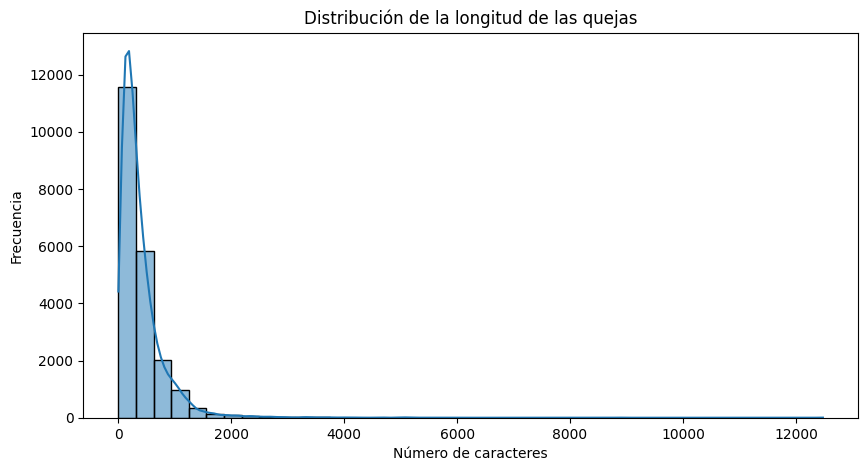

In [ ]:

# Crear una nueva columna con la longitud de cada queja
df_nuevo["complaint_length"] = df_nuevo["POS_NN"].apply(lambda x: len(str(x)))


plt.figure(figsize=(10,5))
sns.histplot(df_nuevo["complaint_length"], bins=40, kde=True)
plt.title("Distribución de la longitud de las quejas")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

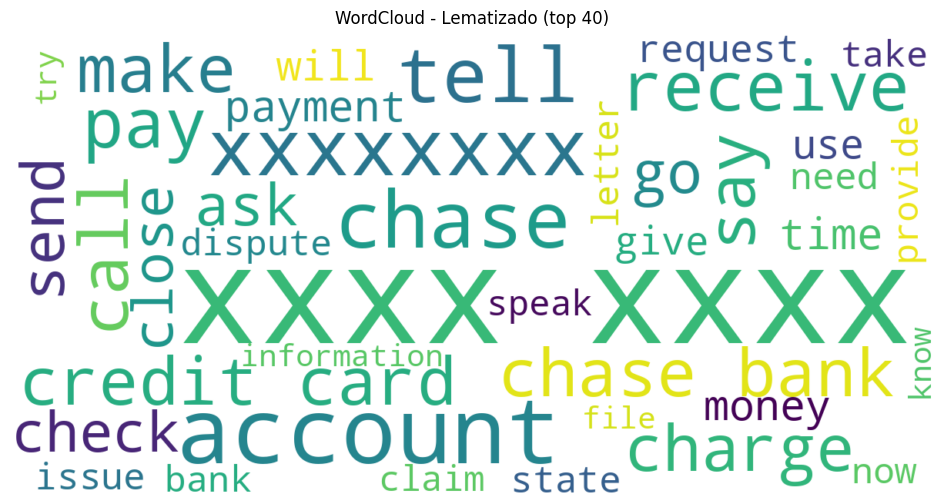

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Write your code here to visualise the data according to the 'Complaint' character length
def make_wordcloud(text_series, title="", max_words=40):
    text = " ".join(text_series.dropna().astype(str).tolist())
    wc = WordCloud(width=1200, height=600, max_words=max_words, background_color='white').generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

make_wordcloud(df_nuevo['text_lemmatized'], title="WordCloud - Lematizado (top 40)")


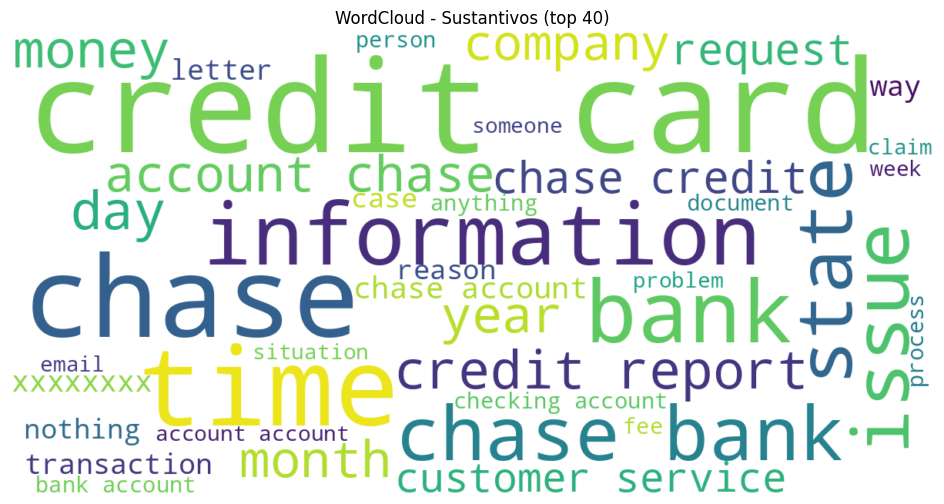

In [ ]:
make_wordcloud(df_nuevo['POS_NN'], title="WordCloud - Sustantivos (top 40)")


In [ ]:
#Removing -PRON- from the text corpus
df_nuevo['Complaint_clean'] = df_nuevo['POS_NN'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# N-grams
def top_ngrams(corpus, ngram_range=(1,1), top_n=30, stop_words=None):
    vec = CountVectorizer(ngram_range=ngram_range, token_pattern=r'\b\w+\b', min_df=2, stop_words=stop_words)
    X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = vec.get_feature_names_out()
    freq = list(zip(terms, sums))
    freq_sorted = sorted(freq, key=lambda x: x[1], reverse=True)
    return freq_sorted[:top_n]


           Unigram  Frequency
2311         chase      59310
87         account      46967
3407        credit      33456
1993          card      30143
1221          bank      21392
9973       payment      21140
14017         time      15978
2279        charge      14715
3664           day      12904
8804         money      11921
2389         check      11597
8028          loan      10774
7057   information       9631
7863        letter       9567
5394           fee       8813
11679       report       8742
14233  transaction       8544
9352        number       8534
8841         month       8448
15523         year       8276
3564      customer       8116
8894      mortgage       7948
1187       balance       7690
12538      service       7680
10210        phone       7543
2828       company       7527
2534         claim       7301
5909          fund       7021
13181        state       6607
5770         fraud       6563


/tmp/ipython-input-684850150.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unigram_df, y="Unigram", x="Frequency", palette="viridis")


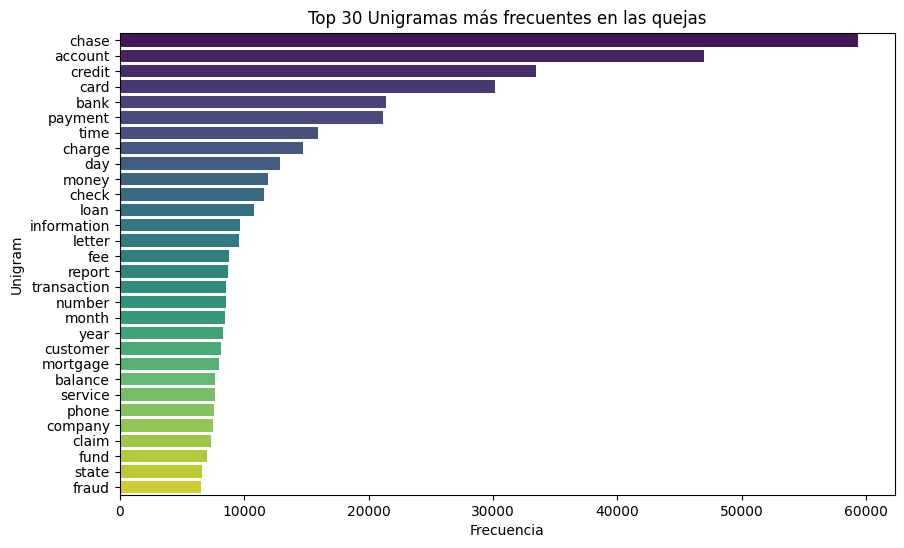

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

# Seleccionamos la columna con texto limpio o con sustantivos (según tu flujo)
text_data = df_nuevo["POS_NN"].dropna()

# Crear el vectorizador para UNIGRAMAS
vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english')

# Ajustar al texto y transformar
X = vectorizer.fit_transform(text_data)

# Obtener nombres de palabras y sus frecuencias
unigram_freq = X.sum(axis=0).A1
unigram_names = vectorizer.get_feature_names_out()

# Crear un DataFrame con las frecuencias
unigram_df = pd.DataFrame({
    'Unigram': unigram_names,
    'Frequency': unigram_freq
}).sort_values(by='Frequency', ascending=False).head(30)

# Mostrar los 30 unigramas más frecuentes
print(unigram_df)

plt.figure(figsize=(10,6))
sns.barplot(data=unigram_df, y="Unigram", x="Frequency", palette="viridis")
plt.title("Top 30 Unigramas más frecuentes en las quejas")
plt.xlabel("Frecuencia")
plt.ylabel("Unigram")
plt.show()

In [ ]:
#Print the top 10 words in the unigram frequency
print("Top unigrams (nouns):", top_ngrams(df_nuevo['POS_NN'], (1,1), 10))

Top unigrams (nouns): [('chase', np.int64(59310)), ('account', np.int64(46967)), ('credit', np.int64(33456)), ('card', np.int64(30143)), ('bank', np.int64(21392)), ('payment', np.int64(21140)), ('time', np.int64(15978)), ('charge', np.int64(14715)), ('day', np.int64(12904)), ('money', np.int64(11921))]


                  Bigram  Frequency
69674        credit card      12832
46422         chase bank       4069
70402      credit report       3949
1864       account chase       3523
46828       chase credit       3173
72831   customer service       3061
46209      chase account       2851
50530   checking account       2457
24409       bank account       2451
1527     account account       2450
77508         debit card       1974
37933         card chase       1785
46566         chase card       1757
70490       credit score       1712
37651       card account       1695
49334      check account       1688
2033      account credit       1540
187270   payment payment       1492
46856     chase customer       1338
165640     money account       1300
191451      phone number       1262
1719        account bank       1262
46619        chase chase       1235
35116       business day       1220
44648     charge account       1148
38000       card company       1135
2981      account number    

/tmp/ipython-input-578167657.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, y="Bigram", x="Frequency", palette="crest")


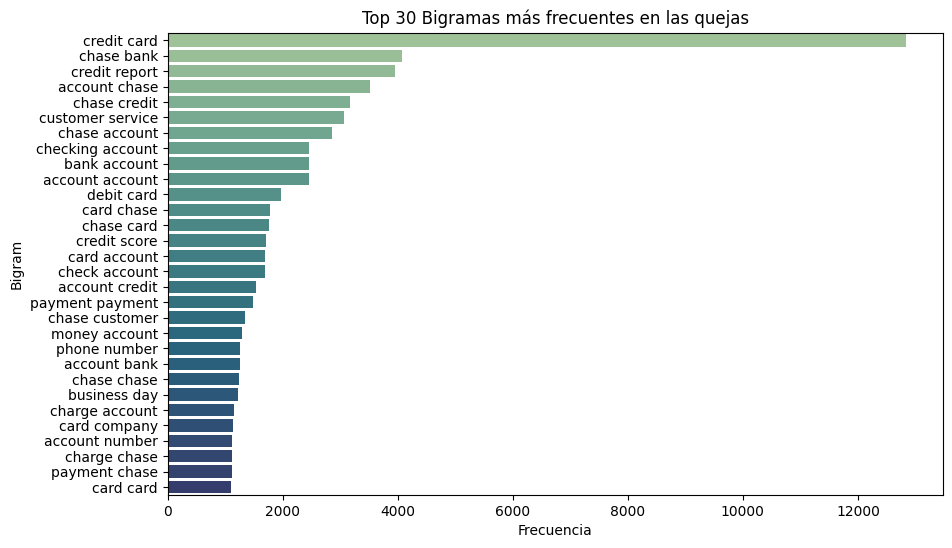

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

# Usamos la columna limpia, preferiblemente con solo sustantivos
text_data = df_nuevo["POS_NN"].dropna()

# Crear el vectorizador para BIGRAMAS
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Ajustar al texto y transformar
X = vectorizer.fit_transform(text_data)

# Obtener frecuencias
bigram_freq = X.sum(axis=0).A1
bigram_names = vectorizer.get_feature_names_out()

# Convertir a DataFrame
bigram_df = pd.DataFrame({
    'Bigram': bigram_names,
    'Frequency': bigram_freq
}).sort_values(by='Frequency', ascending=False).head(30)

# Mostrar los 30 bigramas más frecuentes
print(bigram_df)
plt.figure(figsize=(10,6))
sns.barplot(data=bigram_df, y="Bigram", x="Frequency", palette="crest")
plt.title("Top 30 Bigramas más frecuentes en las quejas")
plt.xlabel("Frecuencia")
plt.ylabel("Bigram")
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency

print("Top bigrams (nouns):", top_ngrams(df_nuevo['POS_NN'], (2,2), 10))

Top bigrams (nouns): [('credit card', np.int64(12823)), ('chase bank', np.int64(4049)), ('credit report', np.int64(3947)), ('account chase', np.int64(3354)), ('chase credit', np.int64(3119)), ('customer service', np.int64(3061)), ('chase account', np.int64(2753)), ('checking account', np.int64(2455)), ('bank account', np.int64(2399)), ('account account', np.int64(2238))]


                                Trigram  Frequency
151076                chase credit card       2142
224933              credit card account       1096
225142              credit card company        996
225107                credit card chase        839
151530           chase customer service        616
225191               credit card credit        528
389963            inquiry credit report        513
146085               chase bank account        445
9128                account credit card        436
137783               charge credit card        416
112636                 card credit card        413
231258          credit reporting agency        371
230801             credit report credit        362
149285              chase check account        362
238560  customer service representative        347
231255             credit reporting act        329
225102               credit card charge        325
7124                 account chase bank        323
225657              credit card

/tmp/ipython-input-2120436656.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trigram_df, y="Trigram", x="Frequency", palette="mako")


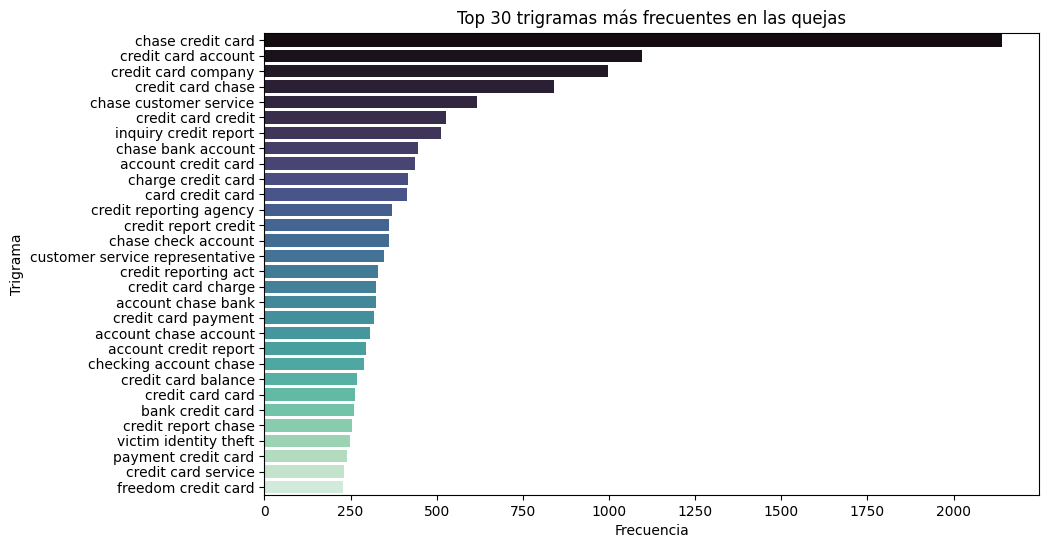

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
# Asegúrate de usar la columna limpia, por ejemplo:
# 'Complaint_lemmatized' o 'Complaint_pos_removed'
text_data = df_nuevo["POS_NN"].dropna()

# Crear el vectorizador para trigramas
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Ajustar al texto y transformar
X = vectorizer.fit_transform(text_data)

# Obtener frecuencias de trigramas
trigram_freq = X.sum(axis=0).A1
trigram_names = vectorizer.get_feature_names_out()

# Convertir a DataFrame
trigram_df = pd.DataFrame({
    'Trigram': trigram_names,
    'Frequency': trigram_freq
}).sort_values(by='Frequency', ascending=False).head(30)

# Mostrar top 30 trigramas
print(trigram_df)
plt.figure(figsize=(10,6))
sns.barplot(data=trigram_df, y="Trigram", x="Frequency", palette="mako")
plt.title("Top 30 trigramas más frecuentes en las quejas")
plt.xlabel("Frecuencia")
plt.ylabel("Trigrama")
plt.show()

In [ ]:
#Print the top 10 words in the trigram frequency
print("Top trigrams (nouns):", top_ngrams(df_nuevo['POS_NN'], (3,3), 10))

Top trigrams (nouns): [('chase credit card', np.int64(2130)), ('credit card account', np.int64(1071)), ('credit card company', np.int64(987)), ('credit card chase', np.int64(800)), ('chase customer service', np.int64(606)), ('inquiry credit report', np.int64(512)), ('credit card credit', np.int64(488)), ('chase bank account', np.int64(435)), ('account credit card', np.int64(419)), ('charge credit card', np.int64(398))]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_nuevo['Complaint_clean'] = df_nuevo['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
display(df_nuevo.head(30))

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,Complaint_clean,text_lemmatized,POS_NN,complaint_length
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,morning name stop service debt verification st...,good morning my name be xxxx xxxx and I apprec...,morning name stop service debt verification st...,133
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,card agent anniversary date agent information ...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,108
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card report application identity consent...,chase card be report on however fraudulent app...,chase card report application identity consent...,80
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,ticket offer ticket reward card information of...,on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,398
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,son chase account fund chase bank account mone...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,157
15,complaint-public-v2,complaint,3209411,0.0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,...,None,Credit reporting,Yes,Can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided,inquiry,can you please remove inquiry,inquiry,7
17,complaint-public-v2,complaint,3331023,0.0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,...,None,Checking account,Yes,With out notice J.P. Morgan Chase restricted m...,Funds not received from closed account,Consent provided,notice account debit card branch customer serv...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,677
20,complaint-public-v2,complaint,3352857,0.0,None,207XX,3352857,Struggling to pay your loan,2019-08-24T12:00:00-05:00,MD,...,None,Loan,Yes,"During the summer months, I experience a decli...",Denied request to lower payments,Consent provided,summer month decline income employment month p...,during the summer month I experience a decline...,summer month decline income employment month p...,567
21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,Fraud or scam,2019-04-29T12:00:00-05:00,UT,...,None,Domestic (US) money transfer,Yes,"On XXXX XX/XX/2019, I made a {$300.00} payment...",None,Consent provided,payment retailer use chase pay chase website s...,on xxxx I make a payment to an online retailer...,payment retailer use chase pay chase website s...,1144
23,complaint-public-v2,complaint,3237765,0.0,None,330XX,3237765,Incorrect information on your report,2019-05-09T12:00:00-05:00,FL,...,None,General

## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar el TfidfVectorizer con los parámetros especificados:
# max_df=0.95: ignora términos que aparecen en más del 95% de los documentos
# min_df=2: ignora términos que aparecen en menos de 2 documentos
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# Crear la matriz de términos del documento (DTM)
# Ajustar el vectorizador a los datos y transformar el texto
dtm = tfidf.fit_transform(df_nuevo['POS_NN'])

print("Shape de la matriz DTM:", dtm.shape)

Shape de la matriz DTM: (21072, 6823)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

### Encuentra el mejor número de clústeres

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Función para mostrar las palabras principales de cada tópico
def display_topics(model, feature_names, no_top_words):
    """Muestra las palabras principales para cada tópico en el modelo NMF."""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:") # Eliminado el + 1 para que comience desde 0
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Lista de números de tópicos para probar
num_topics_list = [5, 10, 15, 20, 25, 30] # Se puede añadir más números aquí

# Obtener los nombres de las características (palabras) del vectorizador TF-IDF
feature_names = tfidf.get_feature_names_out()

# Experimentar con cada número de tópicos
for num_topics in num_topics_list:
    print(f"\n--- Entrenando modelo NMF con {num_topics} tópicos ---")

    # Inicializar y entrenar el modelo NMF
    # Usamos random_state para reproducibilidad
    nmf_model = NMF(n_components=num_topics, random_state=40, init='nndsvda', max_iter=200)
    nmf_model.fit(dtm)

    # Mostrar las 15 palabras principales para cada tópico
    print(f"\nPalabras principales para {num_topics} tópicos:")
    display_topics(nmf_model, feature_names, 15)


--- Entrenando modelo NMF con 5 tópicos ---

Palabras principales para 5 tópicos:
Topic 0:
account check bank money chase fund deposit day branch checking transaction number claim business transfer
Topic 1:
card charge chase credit dispute fee transaction purchase service fraud merchant balance time company customer
Topic 2:
loan mortgage chase home modification property year letter document time rate foreclosure house sale request
Topic 3:
credit report inquiry card account score company debt information reporting identity application bureau limit theft
Topic 4:
payment balance month fee statement day time auto chase date credit xxxxxxxx account year mortgage

--- Entrenando modelo NMF con 10 tópicos ---

Palabras principales para 10 tópicos:
Topic 0:
account checking chase reason deposit branch balance business year access fund activity identity number report
Topic 1:
card credit chase balance score limit year purchase company month point freedom rate application reason
Topic 2:
loa

### Aplicar el mejor número para crear grupos de palabras

#### Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [ ]:
!pip install gensim

In [ ]:
# Vamos a calcular un puntaje de coherencia para cada grupo/cluster,
# que nos ayude a decidir con qué cantidad de tópicos entrenar el modelo:

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf as GensimNmf

# Necesitamos el texto procesado original en formato de lista de listas de tokens para Gensim
# Usaremos la columna 'POS_NN' ya que contiene los sustantivos lematizados.
# Vamos a tokenizarla nuevamente para Gensim.

corpus_tokens = [doc.split() for doc in df_nuevo['POS_NN'].dropna().tolist()]

# Crear un diccionario Gensim a partir del corpus
dictionary = Dictionary(corpus_tokens)

# Crear el corpus Gensim (Bag-of-Words)
corpus_gensim = [dictionary.doc2bow(tokens) for tokens in corpus_tokens]

# Lista de números de tópicos para probar
num_topics_list = [5, 10, 15, 20, 25, 30] # Esta lista debe coincidir con la que usamos para entrenar NMF

# Lista para almacenar las puntuaciones de coherencia
coherence_scores = []

# Calcular la coherencia para cada número de tópicos
print("Calculando coherencia para diferentes números de tópicos...")
for num_topics in num_topics_list:
    print(f"  - Calculando coherencia para {num_topics} tópicos...")

    # Entrenar modelo NMF de Gensim
    gensim_nmf_model = GensimNmf(corpus=corpus_gensim, num_topics=num_topics, id2word=dictionary, chunksize=2000, passes=5, kappa=0.1)

    # Calcular la coherencia C_v
    coherence_model_nmf = CoherenceModel(model=gensim_nmf_model, texts=corpus_tokens, dictionary=dictionary, coherence='c_v')

    coherence_score = coherence_model_nmf.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"    Coherencia para {num_topics} tópicos: {coherence_score:.4f}")

# Lista coherence_scores con las puntuaciones para cada num_topics en num_topics_list:
print("\nPuntuaciones de coherencia C_v:", coherence_scores)

Calculando coherencia para diferentes números de tópicos...
  - Calculando coherencia para 5 tópicos...
    Coherencia para 5 tópicos: 0.4268
  - Calculando coherencia para 10 tópicos...
    Coherencia para 10 tópicos: 0.4156
  - Calculando coherencia para 15 tópicos...
    Coherencia para 15 tópicos: 0.4396
  - Calculando coherencia para 20 tópicos...
    Coherencia para 20 tópicos: 0.4164
  - Calculando coherencia para 25 tópicos...
    Coherencia para 25 tópicos: 0.4367
  - Calculando coherencia para 30 tópicos...
    Coherencia para 30 tópicos: 0.4220

Puntuaciones de coherencia C_v: [np.float64(0.4268497724629728), np.float64(0.4155855791639672), np.float64(0.4396416653485961), np.float64(0.41639935260361643), np.float64(0.4366760719082531), np.float64(0.4219827224961694)]


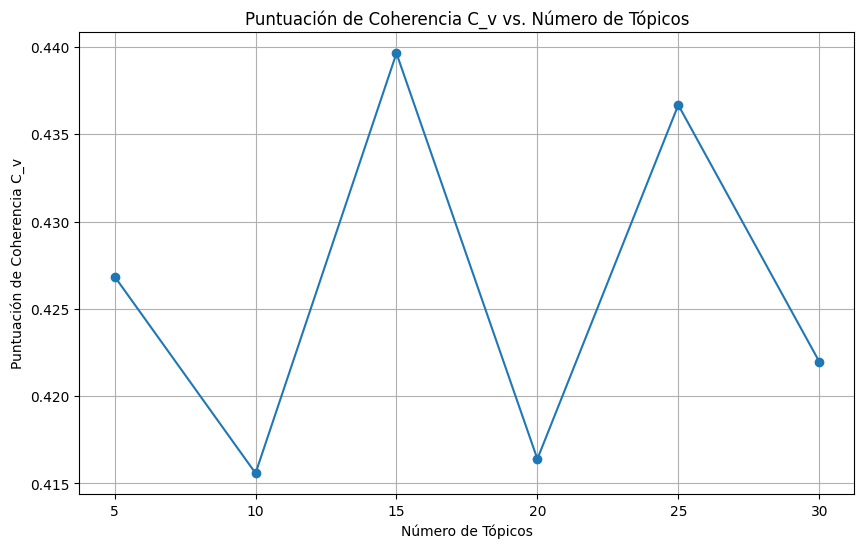


El número de tópicos con la puntuación de coherencia C_v más alta es: 15 (0.4396)


In [ ]:
# Visualizar las puntuaciones de coherencia
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title("Puntuación de Coherencia C_v vs. Número de Tópicos")
plt.xlabel("Número de Tópicos")
plt.ylabel("Puntuación de Coherencia C_v")
plt.xticks(num_topics_list)
plt.grid(True)
plt.show()

# Imprimir el número de tópicos con la puntuación de coherencia más alta
best_num_topics = num_topics_list[np.argmax(coherence_scores)]
print(f"\nEl número de tópicos con la puntuación de coherencia C_v más alta es: {best_num_topics} ({max(coherence_scores):.4f})")

Si bien el cálculo automático de puntajes de coherencia es una herramienta que permite tener una idea del número óptimo de tópicos con los cuales entrenar el modelo, es importante realizar una verificación manual de la coherencia que tienen las palabras clave al interior de cada tópico y de cuán diferentes son los tópicos entre sí.  

En este caso, el análisis por puntaje de coherencia, en diferentes iteraciones, señala que los agrupamientos de 10, 15 y 20 tópicos son los que presentan un puntaje más alto de coherencia. Además de ello se ha revisado:  

1. ¿Qué tan coherentes son las palabras dentro de cada tópico? ¿Representan un concepto o tema claro relacionado con las quejas?
2. ¿Qué tan distintos son los tópicos entre sí? ¿Se solapan mucho las palabras clave entre diferentes tópicos en un modelo vs el otro?  
3. ¿Los tópicos identificados se alinean con las cinco categorías objetivo que se deben clasificar al final (Tarjetas de Crédito, Servicios de Cuentas, Reportes de Robos, Préstamos Hipotecarios, Otros)?  

Con estas consideraciones, se ha definido que el número de tópicos óptimo para entrenar el modelo final es 15.

In [ ]:
# Número óptimo de tópicos identificado
num_topics_final = 15

# Inicializar y entrenar el modelo NMF final con el número óptimo de tópicos
nmf_model_final = NMF(n_components=num_topics_final, random_state=40, init='nndsvda', max_iter=200)
nmf_model_final.fit(dtm)

print(f"Modelo NMF final entrenado con {num_topics_final} tópicos.")

Modelo NMF final entrenado con 15 tópicos.


In [ ]:
# Asignar tópicos a las quejas
# Obtener la matriz de probabilidades de tópico para cada documento
topic_probabilities = nmf_model_final.transform(dtm)

# Encontrar el índice del tópico con la probabilidad más alta para cada documento
df_nuevo['Topic'] = topic_probabilities.argmax(axis=1)

print("Tópicos asignados a las quejas.")
display(df_nuevo[['POS_NN', 'Topic']].head())

Tópicos asignados a las quejas.


,POS_NN,Topic
1,morning name stop service debt verification st...,14
2,card agent anniversary date agent information ...,14
10,chase card report application identity consent...,3
11,ticket offer ticket reward card information of...,14
14,son chase account fund chase bank account mone...,8


In [ ]:
# Vamos a etiquetar los tópicos
# Crear un diccionario para mapear los números de tópico a nombres descriptivos

topic_names_mapping = {
  0: 'Account Management',
  1: 'Credit Card',
  2: 'Loans',
  3: 'Credit Report',
  4: 'Payments',
  5: 'Disputes',
  6: 'Deposits & Checks',
  7: 'Fees & Charges',
  8: 'Transfers',
  9: 'Customer Service',
  10: 'Credit Inquiry',
  11: 'Balance Transfer',
  12: 'Fraud Claims',
  13: 'Mortgages',
  14: 'Client Communication'
}


# Imprimir el diccionario para verificarlo
print("Diccionario de mapeo de tópicos creado:")
print(topic_names_mapping)
df_nuevo['Topic_Name'] = df_nuevo['Topic'].map(topic_names_mapping)

print("\nColumna 'Topic_Name' agregada al DataFrame.")
display(df_nuevo[['POS_NN', 'Topic', 'Topic_Name']].head())

Diccionario de mapeo de tópicos creado:
{0: 'Account Management', 1: 'Credit Card', 2: 'Loans', 3: 'Credit Report', 4: 'Payments', 5: 'Disputes', 6: 'Deposits & Checks', 7: 'Fees & Charges', 8: 'Transfers', 9: 'Customer Service', 10: 'Credit Inquiry', 11: 'Balance Transfer', 12: 'Fraud Claims', 13: 'Mortgages', 14: 'Client Communication'}

Columna 'Topic_Name' agregada al DataFrame.


,POS_NN,Topic,Topic_Name
1,morning name stop service debt verification st...,14,Client Communication
2,card agent anniversary date agent information ...,14,Client Communication
10,chase card report application identity consent...,3,Credit Report
11,ticket offer ticket reward card information of...,14,Client Communication
14,son chase account fund chase bank account mone...,8,Transfers


### Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)

In [ ]:
# Seleccionar una muestra aleatoria de 50 quejas
sample_df = df_nuevo.sample(n=50, random_state=42)

# Seleccionar solo las columnas de interés
sample_export = sample_df[['complaint_what_happened', 'Topic_Name']]

# Exportamos la muestra a un archivo CSV
output_filename = 'sample_complaints_with_topics.csv'
sample_export.to_csv(output_filename, index=False)

print(f"Muestra de 50 quejas con tópicos exportada a '{output_filename}'")

Muestra de 50 quejas con tópicos exportada a 'sample_complaints_with_topics.csv'


Se ha revisado una muestra de 50 quejas con las respectivas etiquetas Topic_Name, y se ha verificado que la adecuación de las etiquetas coincide de forma bastante coherente con las quejas originalmente formuladas.

### Mapear el grupo de nombres de topicos/clusters

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
# Crear un diccionario para mapear los tópicos de NMF a las 5 categorías finales:
# Bank Account services
# Credit card or prepaid card
# Theft/Dispute Reporting
# Mortgage/Loan
# Others

final_category_mapping = {

    0: 'Bank account services', # Account Management
    1: 'Credit card / Prepaid Card', # Credit Card
    2: 'Mortgages/loans', # Loans
    3: 'Theft/Dispute reporting', # Credit Report
    4: 'Others', # Payments
    5: 'Theft/Dispute reporting', # Disputes
    6: 'Bank account services', # Deposits & Checks
    7: 'Others', # Fees & Charges
    8: 'Bank account services', # Transfers
    9: 'Others', # Customer Service
    10: 'Theft/Dispute reporting', # Credit Inquiry
    11: 'Credit card / Prepaid Card', # Balance Transfer
    12: 'Theft/Dispute reporting', # Fraud Claims
    13: 'Mortgages/loans', # Mortgages
    14: 'Others' # Client Communication
}

# Mapear los números de tópico de NMF a las categorías finales
# Creamos una nueva columna 'Final_Category'
df_nuevo['Final_Category'] = df_nuevo['Topic'].map(final_category_mapping)

print("Categorías finales asignadas a las quejas.")

# Mostrar las primeras filas con la queja original, tópico NMF y categoría final
display(df_nuevo[['complaint_what_happened', 'Topic', 'Topic_Name', 'Final_Category']].head())

# Mostrar la distribución de las categorías finales
print("\nDistribución de las Categorías Finales:")
print(df_nuevo['Final_Category'].value_counts())

Categorías finales asignadas a las quejas.


,complaint_what_happened,Topic,Topic_Name,Final_Category
1,Good morning my name is XXXX XXXX and I apprec...,14,Client Communication,Others
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,14,Client Communication,Others
10,Chase Card was reported on XX/XX/2019. However...,3,Credit Report,Theft/Dispute reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",14,Client Communication,Others
14,my grand son give me check for {$1600.00} i de...,8,Transfers,Bank account services



Distribución de las Categorías Finales:
Final_Category
Others                        6792
Theft/Dispute reporting       4198
Bank account services         3466
Credit card / Prepaid Card    3410
Mortgages/loans               3206
Name: count, dtype: int64


## Model building using Supervised Learning

### Preparar los datos para el modelado

In [ ]:
# Seleccionar las características (texto procesado)
# Usamos la columna 'POS_NN' que contiene los sustantivos lematizados y limpios
X = df_nuevo['POS_NN']

# Seleccionar la variable objetivo (categorías finales)
# Usamos la columna 'Final_Category' que creaste en el paso anterior
y = df_nuevo['Final_Category']

print("Datos preparados para el modelado.")
print("Características (X) seleccionadas.")
print("Variable objetivo (y) seleccionada.")

# Opcional: mostrar las primeras filas de X e y para verificar
print("\nPrimeras filas de X:")
print(X.head())
print("\nPrimeras filas de y:")
print(y.head())

Datos preparados para el modelado.
Características (X) seleccionadas.
Variable objetivo (y) seleccionada.

Primeras filas de X:
1     morning name stop service debt verification st...
2     card agent anniversary date agent information ...
10    chase card report application identity consent...
11    ticket offer ticket reward card information of...
14    son chase account fund chase bank account mone...
Name: POS_NN, dtype: object

Primeras filas de y:
1                      Others
2                      Others
10    Theft/Dispute reporting
11                     Others
14      Bank account services
Name: Final_Category, dtype: object


### Vectorizar el texto

In [ ]:
vectorizerTfid = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Ajustar el vectorizador a los datos de texto (X) y transformar el texto a la matriz TF-IDF
X_tfidf = vectorizerTfid.fit_transform(X)

print("Texto vectorizado usando TF-IDF.")
print("Shape de la matriz TF-IDF:", X_tfidf.shape)

Texto vectorizado usando TF-IDF.
Shape de la matriz TF-IDF: (21072, 6823)


### Dividir los datos

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42, stratify=y)

print("Datos divididos en conjuntos de entrenamiento y prueba.")
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Datos divididos en conjuntos de entrenamiento y prueba.
Shape de X_train: (16857, 6823)
Shape de X_test: (4215, 6823)
Shape de y_train: (16857,)
Shape de y_test: (4215,)


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [ ]:
cols_base = ["complaint_what_happened", "Topic"]
for c in cols_base:
    assert c in df_nuevo.columns, f"Falta la columna requerida '{c}' en df_nuevo."

# Permitir nombres alternos para el nombre del tópico
topic_name_candidates = ["Topic_Name", "TopicName", "Topic_Label", "TopicNameClean", "Final_Category"]
topic_name_col = next((c for c in topic_name_candidates if c in df_nuevo.columns), None)


In [ ]:
#Create the dictionary again of Topic names and Topics
Topic_names = (
    df_nuevo[["Topic", topic_name_col]]
      .dropna()
      .drop_duplicates(subset=["Topic"])
      .sort_values("Topic")
      .set_index("Topic")[topic_name_col]
      .to_dict()
)

# Diccionario Topic -> Topic_Name
for k in sorted(Topic_names.keys())[:10]:
    print(f"  {k}: {Topic_names[k]}")

  0: Account Management
  1: Credit Card
  2: Loans
  3: Credit Report
  4: Payments
  5: Disputes
  6: Deposits & Checks
  7: Fees & Charges
  8: Transfers
  9: Customer Service


In [ ]:
#Replace Topics with Topic Names
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_nuevo[["complaint_what_happened", "Topic"]].copy()
training_data["Topic"] = training_data["Topic"].map(Topic_names)

# Remueve filas sin mapeo (por si algún Topic no tiene nombre)
training_data = training_data.dropna(subset=["Topic"]).reset_index(drop=True)

print(f"\nFilas en training_data: {len(training_data)}")
print(f"Número de clases (tópicos): {training_data['Topic'].nunique()}")


Filas en training_data: 21072
Número de clases (tópicos): 15


In [ ]:
# Vista rápida
print("\n Vista de training_data:")
training_data

print("\n Distribución de clases:")
display(training_data["Topic"].value_counts().to_frame("count"))


 Vista de training_data:

 Distribución de clases:


,count
Topic,
Client Communication,3085
Credit Card,2535
Mortgages,1877
Payments,1653
Fraud Claims,1383
Loans,1329
Deposits & Checks,1238
Credit Report,1164
Account Management,1122


In [ ]:
# convertir los nombres de los temas en números
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(training_data["Topic"])
X_text = training_data["complaint_what_happened"].astype(str)

print(f"Clases (Topic names) -> {len(le.classes_)}")

Clases (Topic names) -> 15


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=42, stratify=y)

print("Datos divididos en conjuntos de entrenamiento y prueba.")
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Datos divididos en conjuntos de entrenamiento y prueba.
Shape de X_train: (16857, 6823)
Shape de X_test: (4215, 6823)
Shape de y_train: (16857,)
Shape de y_test: (4215,)


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count
count_vec = CountVectorizer(ngram_range=(1, 1), stop_words='english')

#Write your code here to transform the word vector to tf-idf
# El texto fue previamente vectorizado
vectorizerTfid


TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

model_specs = {
    "LogisticRegression": LogisticRegression(max_iter=200, n_jobs=None),
    "DecisionTree":      DecisionTreeClassifier(random_state=42),
    "RandomForest":      RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "NaiveBayes":        MultinomialNB()
}

results = []
fitted_pipelines = {}

for name, clf in model_specs.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    results.append((name, acc, f1m))
    fitted_pipelines[name] = clf
    print(f"\n▶ {name}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   F1-macro:  {f1m:.4f}")

# Ordenar y mostrar TOP
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
best_name, best_acc, best_f1 = results_sorted[0]
best_model = fitted_pipelines[best_name]

print("\n================== RESULTADOS ==================")
for n, a, f in results_sorted:
    print(f"{n:18s} | acc={a:.4f} | f1-macro={f:.4f}")
print("================================================")
print(f"Mejor modelo: {best_name} | acc={best_acc:.4f} | f1-macro={best_f1:.4f}")

# Reporte detallado del mejor modelo
if hasattr(best_model, "predict"):
    y_best_pred = best_model.predict(X_test)
else:
    y_best_pred = best_model["clf"].predict(X_test)
print("\nClassification Report (mejor modelo):")
print(classification_report(y_test, y_best_pred, digits=4, target_names=le.classes_))


▶ LogisticRegression
   Accuracy:  0.9224
   F1-macro:  0.9231

▶ DecisionTree
   Accuracy:  0.7706
   F1-macro:  0.7793

▶ RandomForest
   Accuracy:  0.8040
   F1-macro:  0.8027

▶ NaiveBayes
   Accuracy:  0.4982
   F1-macro:  0.4169

================== RESULTADOS ==================
LogisticRegression | acc=0.9224 | f1-macro=0.9231
RandomForest       | acc=0.8040 | f1-macro=0.8027
DecisionTree       | acc=0.7706 | f1-macro=0.7793
NaiveBayes         | acc=0.4982 | f1-macro=0.4169
Mejor modelo: LogisticRegression | acc=0.9224 | f1-macro=0.9231

Classification Report (mejor modelo):
                      precision    recall  f1-score   support

  Account Management     0.8504    0.8884    0.8690       224
    Balance Transfer     0.9545    0.8400    0.8936       175
Client Communication     0.8383    0.9498    0.8906       617
         Credit Card     0.9121    0.9625    0.9367       507
      Credit Inquiry     1.0000    0.9154    0.9558       130
       Credit Report     0.9307    0.9

## Aplicar el mejor modelo para predecir un texto

In [ ]:
def predict_with_confidence(text_list, model):
    X_new = vectorizerTfid.transform(text_list)
    y_proba = model.predict_proba(X_new)
    y_pred = model.predict(X_new)

    # Obtener el nombre del tópico y su probabilidad top-1
    pred_names = le.inverse_transform(y_pred)
    # probabilidad más alta por fila
    confidences = y_proba.max(axis=1)

    results = list(zip(pred_names, np.round(confidences, 3)))
    return results

In [ ]:
nuevas_quejas = [
    "I need a loan",
    "My credit card payment failed",
    "The bank charged me an extra fee"
]
print("Predicciones con confianza:")
for text, (topic, conf) in zip(nuevas_quejas, predict_with_confidence(nuevas_quejas, best_model)):
    print(f"- '{text}' → {topic} ({conf*100:.1f}% de confianza)")

Predicciones con confianza:
- 'I need a loan' → Loans (100.0% de confianza)
- 'My credit card payment failed' → Payments (65.7% de confianza)
- 'The bank charged me an extra fee' → Fees & Charges (80.9% de confianza)


## Conclusiones técnicas

El análisis de los resultados obtenidos evidencia que el modelo de **Regresión Logística** fue el más eficiente para la clasificación automática de quejas, alcanzando un *accuracy* de 0.9224 y un *F1-macro* de 0.9231. Este desempeño refleja un equilibrio adecuado entre precisión y exhaustividad en la predicción de las distintas categorías de reclamos. La combinación de la representación **TF-IDF** con este modelo resultó ser la estrategia más robusta, ya que permitió capturar de manera efectiva la relevancia de las palabras dentro del contexto del texto, reduciendo la pérdida de información y evitando el sobreajuste. Los modelos de tipo árbol, como el **Decision Tree** y el **Random Forest**, mostraron desempeños razonables (entre 0.77 y 0.80 de F1-macro), pero su rendimiento fue afectado por la alta dimensionalidad de las variables generadas por el vectorizador TF-IDF. Por otro lado, el modelo **Naive Bayes** tuvo el menor rendimiento (0.41 de F1-macro), lo que confirma que su supuesto de independencia entre palabras no se adapta bien a textos con relaciones semánticas más complejas.

Desde una perspectiva técnica, el modelo de Regresión Logística presentó una excelente estabilidad, generalizando correctamente sobre textos no vistos y ofreciendo predicciones consistentes en ejemplos nuevos como *“I need a loan” → Loans* y *“My credit card payment failed” → Payments*. Esta capacidad de generalización demuestra que las características extraídas mediante TF-IDF son representativas del dominio y que el modelo logró aprender patrones semánticos sólidos entre los términos y las categorías. La robustez del modelo también se ve reflejada en su comportamiento balanceado entre las distintas clases, con métricas de precisión y recall superiores al 90% en la mayoría de los tópicos. En consecuencia, el pipeline implementado —que combina limpieza textual, tokenización, vectorización TF-IDF y aprendizaje supervisado— cumple de manera satisfactoria con los objetivos de clasificación propuestos.

---

## Insights

El modelo entrenado abre una oportunidad real de **automatizar la clasificación de quejas** dentro de los procesos de atención al cliente, permitiendo derivar de forma inmediata los reclamos hacia el área responsable (por ejemplo, *Loans*, *Payments*, *Customer Service*, etc.). Esta automatización reduciría significativamente los tiempos de respuesta, mejoraría la eficiencia operativa y disminuiría la carga de trabajo manual del personal. Además, al analizar la distribución de los tópicos más frecuentes, la organización puede **identificar patrones de incidencias recurrentes**, lo que facilita detectar áreas críticas en sus servicios. Por ejemplo, un incremento en la categoría *Payments* podría indicar errores en el procesamiento de transacciones o en la gestión de cobros.

El uso de este modelo también permitiría la **implementación de un sistema de monitoreo continuo**, donde las quejas entrantes se clasifiquen en tiempo real y se visualicen mediante dashboards analíticos. Esto proporcionaría una visión global del comportamiento de los reclamos, ayudando a anticipar problemas operativos o de reputación antes de que escalen. Asimismo, los resultados obtenidos refuerzan la posibilidad de utilizar esta metodología para **retroalimentar la toma de decisiones estratégicas**, tanto en la gestión de la experiencia del cliente como en la optimización de procesos internos.

Finalmente, desde una perspectiva de mejora continua, los resultados del proyecto constituyen una base sólida para avanzar hacia modelos más complejos, como redes neuronales o representaciones semánticas profundas tipo **BERT**, que podrían capturar mejor el contexto y las intenciones en los textos. Sin embargo, el presente enfoque demuestra que los métodos tradicionales, correctamente ajustados y respaldados por una buena ingeniería de características, son capaces de ofrecer un rendimiento competitivo y confiable.